# PREPROCESAMIENTO DE DATOS PARA LA RED NEURONAL

In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
actual=pd.read_csv('../data/actual.csv')
previos=pd.read_csv('../data/previos.csv')

In [7]:
print(previos.shape)
print(actual.shape)

(925900, 41)
(9259, 27)


comprobacion de que el numero de filas es correcto:

In [8]:
print(previos.shape[0]/actual.shape[0])
num_previos=int(previos.shape[0]/actual.shape[0])

100.0


comprobacion de nulos

In [9]:
actual[actual['round'].isna()]

,idTournament,tournamentName,idSeason,idEvent,round,groundType,periodCount,winnerCode,startTimestamp,year,idHome,birthDateHome,ActualRankingHome,BestRankingHome,HeightHome,WeightHome,RightHandedHome,idAway,birthDateAway,ActualRankingAway,BestRankingAway,HeightAway,WeightAway,RightHandedAway,status,ProbabilityHome,ProbabilityAway


In [10]:
any(previos.drop(columns=['idTournament', 'tournamentName', 'idSeason','round','year']).isna().any(axis=1))

False

Ahora, mirar la depuracion de los partidos que son incorrectos con el target de homeScore-AwayScore, si es grand slam solo puede ser -3,-2,-1,1,2,3 y si no lo es, -2,-1,1,2

Correccion inicial, los grand slams son al mejor de 5

Partidos al mejor de 3

In [11]:
previos_3=previos[previos['periodCount']==3].copy(deep=True)
previos_3['difScore']=previos_3['homeScore']-previos_3['awayScore']
previos_3[['difScore', 'status']].value_counts()

difScore  status
 2.0      100       269298
-2.0      100       247444
 1.0      100       148775
-1.0      100       147055
Name: count, dtype: int64

### al mejor de 5:

In [12]:
previos_5=previos[previos['periodCount']==5].copy(deep=True)
previos_5['difScore']=previos_5['homeScore']-previos_5['awayScore']
previos_5[['difScore', 'status']].value_counts()

difScore  status
 3.0      100       24683
-3.0      100       24275
-2.0      100       19816
 2.0      100       19785
-1.0      100       12562
 1.0      100       12207
Name: count, dtype: int64

In [13]:
previos[['ActualRankingHome', 'ActualRankingAway','BestRankingHome', 'BestRankingAway']].describe()

,ActualRankingHome,ActualRankingAway,BestRankingHome,BestRankingAway
count,925900.000000,925900.000000,925900.000000,925900.000000
mean,766.717422,766.340618,805.003249,804.603832
std,157.774607,157.164849,136.098430,135.409391
min,-100.000000,-100.000000,-100.000000,-100.000000
25%,728.000000,725.000000,778.000000,775.000000
50%,812.000000,812.000000,850.000000,851.000000
75%,865.000000,866.000000,883.000000,883.000000
max,900.000000,900.000000,900.000000,900.000000


# PREPROCESAMIENTO

Esto es para que el ranking en vez de ir de 0 a 899, vaya de 1 a 900. EL ranking ya va asi porque esta cambiado en el scraper


los que son -100 se cambian por 0.1

In [ ]:
actual['ActualRankingAway'] = np.where(actual['ActualRankingAway'] > 0, actual['ActualRankingAway'], 0.1)
actual['ActualRankingHome'] = np.where(actual['ActualRankingHome'] > 0, actual['ActualRankingHome'], 0.1)
actual['BestRankingAway'] = np.where(actual['BestRankingAway'] > 0, actual['BestRankingAway'], 0.1)
actual['BestRankingHome'] = np.where(actual['BestRankingHome'] > 0, actual['BestRankingHome'], 0.1)

El ranking se pone en diferencia porcentual logaritmica<br>
La diferencia logarítmica captura de manera más efectiva la naturaleza del tenis:
La transformación logarítmica del cociente de rankings crea una escala que refleja mejor el impacto real de las diferencias entre jugadores.
Por ejemplo, un log-ratio de magnitud 0.7 podría representar:

Una diferencia entre jugadores de élite (900 vs 450)
Una diferencia entre jugadores de nivel medio (200 vs 100)
Una diferencia entre jugadores de ranking inferior (40 vs 20)

## Cambio en las celdas de probability para sacar la porbabilidad real
En teoría, las probabilidades deberían sumar 1 (o 100%) si representaran perfectamente las probabilidades reales del evento. Sin embargo, en el mundo de las apuestas, casi nunca suman exactamente 1, y esto se debe a algo llamado el "margen del corredor" o "vigorish

Los que son 125, es que es 0.125, mal calculado. Luego, el ultimo viendo la pagina pone 0/1 en initial fractional value, asi que voy a ocger el fractional value

In [ ]:
actual.loc[actual['ProbabilityAway']==125, 'ProbabilityAway'] = 0.125
actual.loc[actual['ProbabilityHome']==125, 'ProbabilityHome'] = 0.125
actual.loc[(actual['ProbabilityHome']==1) & (actual['ProbabilityAway']==1), 'ProbabilityHome'] = 0.1
actual.loc[(actual['ProbabilityHome']==1) & (actual['ProbabilityAway']==1), 'ProbabilityAway'] = 0.943396226

In [16]:
actual[(actual['ProbabilityAway'] >= 1) | (actual['ProbabilityHome'] >= 1)]

,idTournament,tournamentName,idSeason,idEvent,round,groundType,periodCount,winnerCode,startTimestamp,year,idHome,birthDateHome,ActualRankingHome,BestRankingHome,HeightHome,WeightHome,RightHandedHome,idAway,birthDateAway,ActualRankingAway,BestRankingAway,HeightAway,WeightAway,RightHandedAway,status,ProbabilityHome,ProbabilityAway
8933,2436,Beijing,55598,12893659,6,Hardcourt outdoor,3,1,1727420400,2024,289146,1.057622e+09,850.0,857.0,2.03,98.0,1.0,275923,1.052093e+09,898.0,900.0,1.83,74.0,1.0,100,0.1,1.0


In [17]:
def procesar_probabilidades(df):
    """Procesa las probabilidades: normaliza y calcula margen"""
    # Verificar si las columnas existen
    if 'ProbabilityHome' not in df.columns or 'ProbabilityAway' not in df.columns:
        print("Error: Columnas de probabilidades no encontradas")
        return df
    
    # Calcular el margen (vigorish)
    df['vigorish'] = (df['ProbabilityHome'] + df['ProbabilityAway']) - 1
    
    # Normalizar probabilidades
    suma = df['ProbabilityHome'] + df['ProbabilityAway']
    df['probability_home'] = df['ProbabilityHome'] / suma
    df['probability_away'] = df['ProbabilityAway'] / suma
    
    # Manejar valores NaN
    mask = suma > 0
    df['probability_home'] = df['probability_home'].where(mask, None)
    df['probability_away'] = df['probability_away'].where(mask, None)
    
    # Eliminar columnas originales si es necesario
    df.drop(columns=['ProbabilityHome', 'ProbabilityAway'], inplace=True)
    
    return df

# Aplicar el procesamiento
actual = procesar_probabilidades(actual)

In [19]:
actual.head(10)

,idTournament,tournamentName,idSeason,idEvent,round,groundType,periodCount,winnerCode,startTimestamp,year,idHome,birthDateHome,ActualRankingHome,BestRankingHome,HeightHome,WeightHome,RightHandedHome,idAway,birthDateAway,ActualRankingAway,BestRankingAway,HeightAway,WeightAway,RightHandedAway,status,vigorish,probability_home,probability_away
0,2363,Australian Open,35210,9273844,60,Hardcourt outdoor,3,1,1610263800,2021,38517,633744000.0,658.0,789.0,1.78,80.0,1.0,71660,803174400.0,692.0,856.0,1.88,78.0,0.0,100,0.069672,0.233716,0.766284
1,2363,Australian Open,35210,9273823,60,Hardcourt outdoor,3,0,1610263800,2021,17018,702000000.0,768.0,808.0,1.85,78.0,1.0,15958,517017600.0,665.0,837.0,1.78,76.0,1.0,100,0.075536,0.607692,0.392308
2,2363,Australian Open,35210,9273866,60,Hardcourt outdoor,3,1,1610263800,2021,15743,526435200.0,718.0,868.0,1.85,85.0,1.0,48626,684460800.0,750.0,774.0,1.80,80.0,1.0,100,0.078600,0.558511,0.441489
3,2363,Australian Open,35210,9273849,60,Hardcourt outdoor,3,0,1610263800,2021,48632,728092800.0,785.0,837.0,1.91,84.0,1.0,51309,746668800.0,670.0,690.0,1.93,82.0,1.0,100,0.051948,0.864198,0.135802
4,2363,Australian Open,35210,9273842,60,Hardcourt outdoor,3,0,1610263800,2021,124916,888537600.0,678.0,684.0,1.96,90.0,1.0,83397,831859200.0,742.0,775.0,1.91,81.0,1.0,100,0.075663,0.577428,0.422572
5,2363,Australian Open,35210,9273869,60,Hardcourt outdoor,3,1,1610263800,2021,52462,720144000.0,657.0,765.0,1.78,69.0,1.0,36298,669168000.0,724.0,767.0,1.75,76.0,1.0,100,0.075536,0.392308,0.607692
6,2363,Australian Open,35210,9273812,60,Hardcourt outdoor,3,1,1610263800,2021,54387,830044800.0,423.0,681.0,1.80,77.0,1.0,83661,829094400.0,697.0,796.0,1.85,78.0,1.0,100,0.081387,0.410995,0.589005
7,2363,Australian Open,35210,9273854,60,Hardcourt outdoor,3,1,1610269200,2021,38183,636076800.0,776.0,846.0,1.83,82.0,0.0,58877,784252800.0,713.0,790.0,1.88,81.0,1.0,100,0.081387,0.410995,0.589005
8,2363,Australian Open,35210,9273851,60,Hardcourt outdoor,3,1,1610270100,2021,24474,667180800.0,384.0,862.0,1.83,70.0,1.0,137810,890784000.0,655.0,665.0,1.88,78.0,1.0,100,0.066667,0.625000,0.375000
9,2363,Australian Open,35210,9273833,60,Hardcourt outdoor,3,1,1610270400,2021,83263,864259200.0,619.0,757.0,1.80,78.0,1.0,145112,835574400.0,754.0,755.0,1.96,86.0,0.0,100,0.077922,0.337349,0.662651


In [20]:
previos.head(10)

,idTournament,tournamentName,idSeason,idEvent,round,groundType,periodCount,winnerCode,idNext,startTimestamp,lastMatchTimestamp,year,idHome,birthDateHome,ActualRankingHome,BestRankingHome,HeightHome,WeightHome,RightHandedHome,idAway,birthDateAway,ActualRankingAway,BestRankingAway,HeightAway,WeightAway,RightHandedAway,status,homeScore,awayScore,set1performanceHome,set1performanceAway,set2performanceHome,set2performanceAway,set3performanceHome,set3performanceAway,set4performanceHome,set4performanceAway,set5performanceHome,set5performanceAway,totalGamesHome,totalGamesAway
0,2361,Wimbledon,20189,8262676,44,Grass,5,1,8273971,1561386900,1558356900,2019,38517,633744000.0,736.0,789.0,1.78,80.0,1.0,16192,558057600.0,517.0,852.0,1.85,87.0,1.0,100,2.0,0.0,6,7,5,7,0,0,0,0,0,0,11.0,14.0
1,13646,"Ludwigshafen, Germany",23784,8273971,24,Clay,3,1,8289007,1561971600,1561386900,2019,38517,633744000.0,739.0,789.0,1.78,80.0,1.0,53483,784080000.0,652.0,698.0,1.83,78.0,1.0,100,2.0,1.0,7,5,5,7,4,6,0,0,0,0,16.0,18.0
2,3490,"Braunschweig, Germany",23787,8289007,25,Red clay,3,0,8291130,1562665800,1561971600,2019,38517,633744000.0,739.0,789.0,1.78,80.0,1.0,16198,601257600.0,581.0,620.0,1.78,79.0,0.0,100,2.0,0.0,7,6,6,4,0,0,0,0,0,0,13.0,10.0
3,3490,"Braunschweig, Germany",23787,8291130,26,Red clay,3,1,8301344,1562757300,1562665800,2019,38517,633744000.0,739.0,789.0,1.78,80.0,1.0,177686,911260800.0,502.0,626.0,1.80,73.0,0.0,100,0.0,2.0,2,6,4,6,0,0,0,0,0,0,6.0,12.0
4,2426,Umag,20260,8301344,26,Red clay,3,0,8302965,1563091200,1562757300,2019,38517,633744000.0,739.0,789.0,1.78,80.0,1.0,48409,695347200.0,454.0,572.0,1.78,78.0,0.0,100,2.0,0.0,7,5,7,5,0,0,0,0,0,0,14.0,10.0
5,2426,Umag,20260,8302965,164,Red clay,3,0,8305051,1563199200,1563091200,2019,38517,633744000.0,740.0,789.0,1.78,80.0,1.0,42152,797558400.0,723.0,749.0,1.96,90.0,1.0,100,2.0,1.0,6,7,6,2,6,3,0,0,0,0,18.0,12.0
6,2426,Umag,20260,8305051,25,Red clay,3,1,8317515,1563287400,1563199200,2019,38517,633744000.0,740.0,789.0,1.78,80.0,1.0,90110,850435200.0,611.0,709.0,1.91,85.0,1.0,100,0.0,2.0,3,6,3,6,0,0,0,0,0,0,6.0,12.0
7,2416,Gstaad,20264,8317515,64,Red clay,3,0,8318491,1563613200,1563287400,2019,38517,633744000.0,740.0,789.0,1.78,80.0,1.0,113993,882403200.0,0.1,225.0,1.85,78.0,1.0,100,2.0,1.0,4,6,6,3,7,5,0,0,0,0,17.0,14.0
8,2416,Gstaad,20264,8318491,164,Red clay,3,1,8337312,1563699600,1563613200,2019,38517,633744000.0,740.0,789.0,1.78,80.0,1.0,100097,887328000.0,660.0,689.0,1.85,81.0,1.0,100,0.0,2.0,3,6,2,6,0,0,0,0,0,0,5.0,12.0
9,5812,"Liberec, Czech Republic",23811,8337312,25,Red clay,3,1,8365524,1564560000,1563699600,2019,38517,633744000.0,691.0,789.0,1.78,80.0,1.0,121182,816393600.0,569.0,569.0,1.98,82.0,1.0,100,2.0,0.0,3,6,4,6,0,0,0,0,0,0,7.0,12.0


## Paso a diferencias:

In [ ]:
def transformar_actual(df, actual=True):
    df_return=pd.DataFrame()
    # Variables que no cambian
    df_return['idEvent']=df['idEvent']
    df_return['year']=df['year']
    df_return['startTimestamp']=df['startTimestamp']
    df_return['winnerCode']=df['winnerCode']
    df_return['groundType']=df['groundType']
    df_return['periodCount']=df['periodCount']
    if actual:
        df_return['vigorish'] = df['vigorish']
        df_return['probability_home'] = df['probability_home']
        df_return['probability_away'] = df['probability_away']

    # va al revés para que sea positivo, la gente más mayor tiene un time stamp mas pequeño
    df_return['difBirthDate']=df['birthDateAway']-df['birthDateHome']
    df_return['porcentajeActualRanking'] = np.log(df['ActualRankingHome'] / (df['ActualRankingAway'] )) 
    df_return['porcentajeBestRanking'] = np.log(df['BestRankingHome'] / (df['BestRankingAway'] )) 
    df_return['difHeight']=df['HeightHome']-df['HeightAway']
    df_return['difWeight']=df['WeightHome']-df['WeightAway']
    df_return['difLaterality']=df['RightHandedHome'].astype(int).astype(str)  + df['RightHandedAway'].astype(int).astype(str)

    return df_return

In [ ]:
actual2=transformar_actual(actual)

## One hot encoding para variables categoricas

In [23]:
actual2 = pd.get_dummies(actual2, columns=['groundType', 'difLaterality'], dtype=int)
actual2=actual2.rename(columns={'groundType_Red clay':'groundType_Red_clay' ,
                              'groundType_Hardcourt indoor':'groundType_Hardcourt_indoor' ,'groundType_Hardcourt outdoor':'groundType_Hardcourt_outdoor' })

In [26]:
actual2[actual2.drop(columns=['vigorish', 'probability_home', 'probability_away']).isna().any(axis=1)]

,idEvent,year,startTimestamp,winnerCode,periodCount,vigorish,probability_home,probability_away,difBirthDate,porcentajeActualRanking,porcentajeBestRanking,difHeight,difWeight,groundType_Grass,groundType_Hardcourt_indoor,groundType_Hardcourt_outdoor,groundType_Red_clay,difLaterality_00,difLaterality_01,difLaterality_10,difLaterality_11


In [ ]:
previos=previos.copy(deep=True)
actual_diferencias=actual2.copy(deep=True)
print(actual_diferencias.shape, previos.shape)

(9259, 21) (925900, 25) (9259, 28) (925900, 41)


#### Se va a meter a la red. A la capa lstm los resultados sin diferencias, para que puedan capturar tendencias, y a la capa actual las diferencias

## Preparación de datos sin diferencias para la capa lstm

In [31]:
from datetime import datetime
# Convertir cada timestamp a datetime usando apply
start_times = previos['startTimestamp'].apply(datetime.fromtimestamp)
last_match_times = previos['lastMatchTimestamp'].apply(datetime.fromtimestamp)
# Calcular la diferencia (esto da una serie de objetos timedelta)
diferencia = start_times - last_match_times
diferencia_dias = diferencia.dt.days
previos['days_no_played'] = diferencia_dias

In [ ]:
previos['best_five']= np.where(previos['periodCount'] == 5, 1, 0)
start_times = previos['startTimestamp'].apply(datetime.fromtimestamp)
birth_home = previos['birthDateHome'].apply(datetime.fromtimestamp)
birth_away = previos['birthDateAway'].apply(datetime.fromtimestamp)
# Calcular la diferencia (esto da una serie de objetos timedelta)
diferencia_home = start_times - birth_home
diferencia_away = start_times - birth_away
# calcular los años, dividiendo por 365.25
diferencia_home_anos = diferencia_home.dt.days / 365.25
diferencia_away_anos = diferencia_away.dt.days / 365.25
previos['edad_home'] = diferencia_home_anos
previos['edad_away'] = diferencia_away_anos

In [ ]:
previos = previos.replace({'groundType': {'Clay':'Red clay', 'Red clay indoor':'Red clay', 'Carpet indoor':'Hardcourt indoor'}})
previos = pd.get_dummies(previos, columns=['groundType'], dtype=int)
previos=previos.rename(columns={'groundType_Red clay':'groundType_Red_clay' ,
                             'groundType_Hardcourt indoor':'groundType_Hardcourt_indoor' ,'groundType_Hardcourt outdoor':'groundType_Hardcourt_outdoor' })
previos.drop(columns=['idTournament', 'tournamentName', 'idSeason', 'idEvent', 'round','periodCount','idNext', 'idHome', 'idAway','status','year', 'startTimestamp','lastMatchTimestamp', 
                      'birthDateHome','birthDateAway',], inplace=True)

Pasar el 0.1 de los rankings a no rankeado

In [ ]:
previos['ActualRankingHome']=previos['ActualRankingHome'].replace(-100, 0)
previos['ActualRankingAway']=previos['ActualRankingAway'].replace(-100, 0)
previos['BestRankingHome']=previos['BestRankingHome'].replace(-100, 0)
previos['BestRankingAway']=previos['BestRankingAway'].replace(-100, 0)
previos[['ActualRankingHome', 'ActualRankingAway', 'BestRankingHome', 'BestRankingAway']].describe()

In [38]:
previos['RightHandedAway']=previos['RightHandedAway'].astype(int)
previos['RightHandedHome']=previos['RightHandedHome'].astype(int)

In [39]:
previos.head()

,winnerCode,ActualRankingHome,BestRankingHome,HeightHome,WeightHome,RightHandedHome,ActualRankingAway,BestRankingAway,HeightAway,WeightAway,RightHandedAway,homeScore,awayScore,set1performanceHome,set1performanceAway,set2performanceHome,set2performanceAway,set3performanceHome,set3performanceAway,set4performanceHome,set4performanceAway,set5performanceHome,set5performanceAway,totalGamesHome,totalGamesAway,days_no_played,best_five,edad_home,edad_away,groundType_Grass,groundType_Hardcourt_indoor,groundType_Hardcourt_outdoor,groundType_Red_clay
0,1,736.0,789.0,1.78,80.0,1,517.0,852.0,1.85,87.0,1,2.0,0.0,6,7,5,7,0,0,0,0,0,0,11.0,14.0,35,1,29.393566,31.791923,1,0,0,0
1,1,739.0,789.0,1.78,80.0,1,652.0,698.0,1.83,78.0,1,2.0,1.0,7,5,5,7,4,6,0,0,0,0,16.0,18.0,6,0,29.412731,24.648871,0,0,0,1
2,0,739.0,789.0,1.78,80.0,1,581.0,620.0,1.78,79.0,0,2.0,0.0,7,6,6,4,0,0,0,0,0,0,13.0,10.0,8,0,29.434634,30.464066,0,0,0,1
3,1,739.0,789.0,1.78,80.0,1,502.0,626.0,1.80,73.0,0,0.0,2.0,2,6,4,6,0,0,0,0,0,0,6.0,12.0,1,0,29.437372,20.643395,0,0,0,1
4,0,739.0,789.0,1.78,80.0,1,454.0,572.0,1.78,78.0,0,2.0,0.0,7,5,7,5,0,0,0,0,0,0,14.0,10.0,3,0,29.448323,27.496235,0,0,0,1


### Datos con diferencias

Actual:

In [40]:
actual_diferencias.head()

,idEvent,year,startTimestamp,winnerCode,periodCount,vigorish,probability_home,probability_away,difBirthDate,porcentajeActualRanking,porcentajeBestRanking,difHeight,difWeight,groundType_Grass,groundType_Hardcourt_indoor,groundType_Hardcourt_outdoor,groundType_Red_clay,difLaterality_00,difLaterality_01,difLaterality_10,difLaterality_11
0,9273844,2021,1610263800,1,3,0.069672,0.233716,0.766284,169430400.0,-0.050381,-0.081504,-0.10,2.0,0,0,1,0,0,0,1,0
1,9273823,2021,1610263800,0,3,0.075536,0.607692,0.392308,-184982400.0,0.144003,-0.035262,0.07,2.0,0,0,1,0,0,0,0,1
2,9273866,2021,1610263800,1,3,0.078600,0.558511,0.441489,158025600.0,-0.043604,0.114620,0.05,5.0,0,0,1,0,0,0,0,1
3,9273849,2021,1610263800,0,3,0.051948,0.864198,0.135802,18576000.0,0.158406,0.193132,-0.02,2.0,0,0,1,0,0,0,0,1
4,9273842,2021,1610263800,0,3,0.075663,0.577428,0.422572,-56678400.0,-0.090202,-0.124905,0.05,9.0,0,0,1,0,0,0,0,1


In [ ]:
actual_diferencias['best_five']= np.where(actual_diferencias['periodCount'] == 5, 1, 0)
# Convertir diferencias de timestamp en años
# 365.25 días × 24 horas × 60 minutos × 60 segundos = 31557600 segundos en un año
diferencia_en_anos = actual_diferencias['difBirthDate'] / 31557600
actual_diferencias['difYear'] = diferencia_en_anos

In [43]:
# Convertir el timestamp a fecha
date = pd.to_datetime(actual_diferencias['startTimestamp'], unit='s')

# Obtener año y semana como tupla (año, semana)
year_week = date.apply(
    lambda fecha: (fecha.isocalendar().year, fecha.isocalendar().week)
)
# Obtener lista única de combinaciones (año, semana) ordenadas cronológicamente
unique_year_weeks = sorted(year_week.unique())

# Crear un diccionario que mapee cada (año, semana) a un identificador secuencial
week_to_id = {yw: idx for idx, yw in enumerate(unique_year_weeks)}
actual_diferencias['year_week_id'] = year_week.map(week_to_id)

In [ ]:
actual_diferencias.drop(columns=['idEvent',	'year','startTimestamp','periodCount','difBirthDate'], inplace=True)
actual_diferencias.head()

,winnerCode,vigorish,probability_home,probability_away,porcentajeActualRanking,porcentajeBestRanking,difHeight,difWeight,groundType_Grass,groundType_Hardcourt_indoor,groundType_Hardcourt_outdoor,groundType_Red_clay,difLaterality_00,difLaterality_01,difLaterality_10,difLaterality_11,best_five,difYear,year_week_id
0,1,0.069672,0.233716,0.766284,-0.050381,-0.081504,-0.10,2.0,0,0,1,0,0,0,1,0,0,5.368925,0
1,0,0.075536,0.607692,0.392308,0.144003,-0.035262,0.07,2.0,0,0,1,0,0,0,0,1,0,-5.861739,0
2,1,0.078600,0.558511,0.441489,-0.043604,0.114620,0.05,5.0,0,0,1,0,0,0,0,1,0,5.007529,0
3,0,0.051948,0.864198,0.135802,0.158406,0.193132,-0.02,2.0,0,0,1,0,0,0,0,1,0,0.588638,0
4,0,0.075663,0.577428,0.422572,-0.090202,-0.124905,0.05,9.0,0,0,1,0,0,0,0,1,0,-1.796030,0


## Estandarizacion de variables
Para la capa de concatenación (diferencias):

StandardScaler para todas las variables, incluyendo:

porcentajeActualRanking (que ya tiene la transformación logarítmica)
porcentajeBestRanking (también con transformación logarítmica)
difHeight
difWeight
difYear

In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

columnas_scale_actual=['porcentajeActualRanking','porcentajeBestRanking','difHeight','difWeight','difYear']
scaler_actual = StandardScaler()    
actual_diferencias[columnas_scale_actual] = scaler_actual.fit_transform(actual_diferencias[columnas_scale_actual])
actual_diferencias.head()

,winnerCode,vigorish,probability_home,probability_away,porcentajeActualRanking,porcentajeBestRanking,difHeight,difWeight,groundType_Grass,groundType_Hardcourt_indoor,groundType_Hardcourt_outdoor,groundType_Red_clay,difLaterality_00,difLaterality_01,difLaterality_10,difLaterality_11,best_five,difYear,year_week_id
0,1,0.069672,0.233716,0.766284,-0.096934,-0.520517,-1.044343,0.228463,0,0,1,0,0,0,1,0,0,0.859275,0
1,0,0.075536,0.607692,0.392308,0.177778,-0.246956,0.738353,0.228463,0,0,1,0,0,0,0,1,0,-0.943432,0
2,1,0.078600,0.558511,0.441489,-0.087356,0.639723,0.528624,0.561874,0,0,1,0,0,0,0,1,0,0.801265,0
3,0,0.051948,0.864198,0.135802,0.198134,1.104192,-0.205428,0.228463,0,0,1,0,0,0,0,1,0,0.091960,0
4,0,0.075663,0.577428,0.422572,-0.153211,-0.777271,0.528624,1.006422,0,0,1,0,0,0,0,1,0,-0.290819,0


In [48]:
columnas_standard_scale_previos=['HeightHome','WeightHome','HeightAway','WeightAway','edad_home','edad_away','days_no_played']
columnas_minmax_scale_previos=['ActualRankingHome','BestRankingHome','ActualRankingAway','BestRankingAway','homeScore','awayScore','set1performanceHome','set1performanceAway',
                               'set2performanceHome','set2performanceAway','set3performanceHome','set3performanceAway',
                               'set4performanceHome','set4performanceAway','set5performanceHome','set5performanceAway','totalGamesHome','totalGamesAway']
scaler_previos_minmax = MinMaxScaler()
scaler_previos_standard = StandardScaler()
previos[columnas_standard_scale_previos] = scaler_previos_standard.fit_transform(previos[columnas_standard_scale_previos])
previos[columnas_minmax_scale_previos] = scaler_previos_minmax.fit_transform(previos[columnas_minmax_scale_previos])
previos.head()

,winnerCode,ActualRankingHome,BestRankingHome,HeightHome,WeightHome,RightHandedHome,ActualRankingAway,BestRankingAway,HeightAway,WeightAway,RightHandedAway,homeScore,awayScore,set1performanceHome,set1performanceAway,set2performanceHome,set2performanceAway,set3performanceHome,set3performanceAway,set4performanceHome,set4performanceAway,set5performanceHome,set5performanceAway,totalGamesHome,totalGamesAway,days_no_played,best_five,edad_home,edad_away,groundType_Grass,groundType_Hardcourt_indoor,groundType_Hardcourt_outdoor,groundType_Red_clay
0,1,0.817778,0.876667,-1.264435,0.031102,1,0.574444,0.946667,-0.248839,1.110974,1,0.666667,0.000000,0.6,0.7,0.5,0.7,0.00,0.000000,0.0,0.0,0.0,0.0,0.275,0.35,2.049115,1,0.661493,1.198959,1,0,0,0
1,1,0.821111,0.876667,-1.264435,0.031102,1,0.724444,0.775556,-0.540683,-0.289252,1,0.666667,0.333333,0.7,0.5,0.5,0.7,0.25,0.428571,0.0,0.0,0.0,0.0,0.400,0.45,0.064228,0,0.665848,-0.414577,0,0,0,1
2,0,0.821111,0.876667,-1.264435,0.031102,1,0.645556,0.688889,-1.270293,-0.133672,0,0.666667,0.000000,0.7,0.6,0.6,0.4,0.00,0.000000,0.0,0.0,0.0,0.0,0.325,0.25,0.201117,0,0.670825,0.899011,0,0,0,1
3,1,0.821111,0.876667,-1.264435,0.031102,1,0.557778,0.695556,-0.978449,-1.067156,0,0.000000,0.666667,0.2,0.6,0.4,0.6,0.00,0.000000,0.0,0.0,0.0,0.0,0.150,0.30,-0.277993,0,0.671447,-1.319369,0,0,0,1
4,0,0.821111,0.876667,-1.264435,0.031102,1,0.504444,0.635556,-1.270293,-0.289252,0,0.666667,0.000000,0.7,0.5,0.7,0.5,0.00,0.000000,0.0,0.0,0.0,0.0,0.350,0.25,-0.141105,0,0.673935,0.228611,0,0,0,1


## SOLO ESTÁ ESCALADO LO QUE ENTRA A LA RED, ACTUAL DIFERENCIAS Y PREVIOS SIN DIFERENCIAS

In [ ]:
actual_diferencias.to_csv('data/actual_diferencias_preproc_escalado.csv', index=False)
previos.to_csv('data/previos_preproc_escalado.csv', index=False)

## Análisis de relacion entre variables

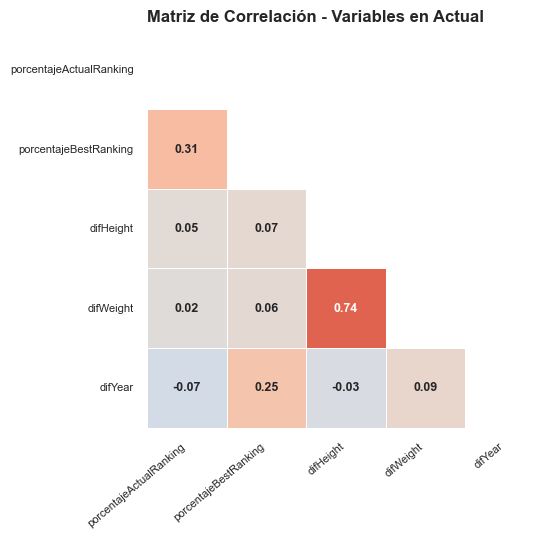

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Preparar los datos
actual_corr = actual_diferencias.drop(columns=[
    'winnerCode', 'probability_home', 'probability_away', 'vigorish', 'year_week_id',
    'groundType_Grass', 'groundType_Hardcourt_indoor', 'groundType_Hardcourt_outdoor', 
    'groundType_Red_clay', 'difLaterality_00', 'difLaterality_01', 'difLaterality_10', 
    'difLaterality_11', 'best_five'
])

correlation_matrix = actual_corr.corr()

# Estilo general
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(style="white", palette="deep")

# Crear la figura
fig, ax = plt.subplots(figsize=(6, 6))

# Máscara para el triángulo superior
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Heatmap sin barra lateral
heatmap = sns.heatmap(
    correlation_matrix,
    mask=mask,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    center=0,
    square=True,
    annot=True,
    fmt='.2f',
    annot_kws={'size': 9, 'weight': 'bold'},
    linewidths=0.7,
    linecolor='white',
    cbar=False  # Elimina la barra de la derecha
)

# Títulos y etiquetas
plt.title('Matriz de Correlación - Variables en Actual', 
          fontsize=12, weight='bold',loc='left')

# Rotar etiquetas de los ejes
plt.xticks(rotation=40, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)

# Ajustar el layout
plt.tight_layout(pad=2)

plt.show()


C:\Users\diego\AppData\Local\Temp\ipykernel_17868\931116018.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


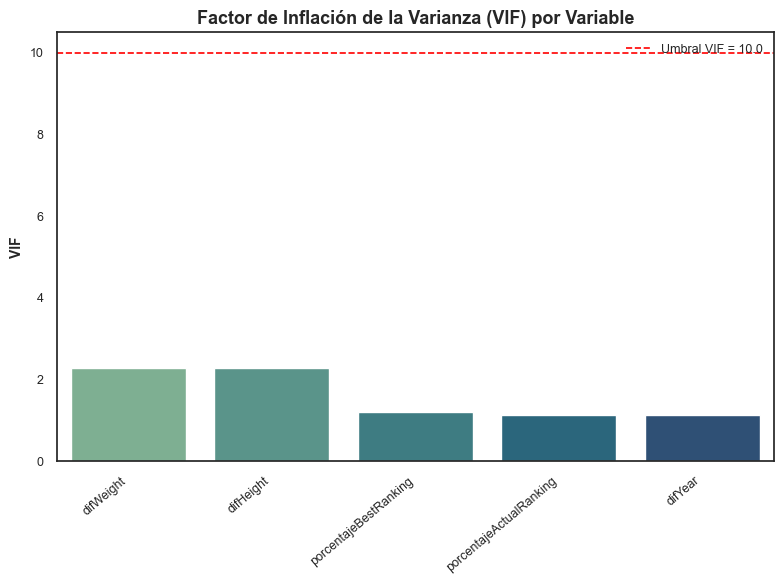

In [92]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def seleccionar_variables_vif(df, threshold=10.0):
    df_numeric=df.copy()
    df_numeric = df.select_dtypes(include=[np.number]).copy()
    features = df_numeric.columns.tolist()

    #porque me dice que da un resultado dividiendo por 0, entonces el vif es infinito
    import warnings
    warnings.simplefilter("ignore", RuntimeWarning)

    # Eliminar variables con alto VIF iterativamente
    for i in range(len(features)-1):
        try:
            vif_df = pd.DataFrame()
            vif_df["Variable"] = features
            vif_df["VIF"] = [variance_inflation_factor(df_numeric[features].values, j) 
                            for j in range(len(features))]
            
            vif_df["VIF"] = vif_df["VIF"].replace([np.inf, -np.inf], 1e15)


            max_vif = vif_df['VIF'].max()
            
            if max_vif < threshold:
                break
                
            # Eliminar la variable con el VIF más alto
            feature_to_remove = vif_df.loc[vif_df['VIF'] == max_vif, 'Variable'].values[0]
            features.remove(feature_to_remove)

            if(len(features)==1):
                break
            
        except Exception:
            print('error')
            if(len(features)>1):
                features.pop(0)
            else:
                break
        
    final_vif = pd.DataFrame()
    final_vif["Variable"] = features
    final_vif["VIF"] = [variance_inflation_factor(df_numeric[features].values, j) 
                           for j in range(len(features))]
    #final_vif = final_vif.sort_values("VIF", ascending=False)
    
    
    return final_vif

threshold=10.0
final_vif= seleccionar_variables_vif(actual_corr, threshold)
final_vif_sorted = final_vif.sort_values(by="VIF", ascending=False)

# Estilo limpio sin gridlines
sns.set_style("white")

# Crear figura
plt.figure(figsize=(8, 6))
barplot = sns.barplot(
    x="Variable", 
    y="VIF", 
    data=final_vif_sorted,
    palette="crest"
)

# Línea del umbral
plt.axhline(y=threshold, color='red', linestyle='--', linewidth=1.2, label=f'Umbral VIF = {threshold}')

# Títulos y ejes
plt.title('Factor de Inflación de la Varianza (VIF) por Variable', fontsize=13, weight='bold', loc='center')
plt.xticks(rotation=40, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.xlabel('')
plt.ylabel('VIF', fontsize=10, weight='bold')
plt.legend(fontsize=9, loc='upper right')

# Ajustar el layout
plt.tight_layout()
plt.show()

